In [2]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from matplotlib import pyplot
import scipy.stats as st
import scipy.signal
import scipy.integrate
import pandas
import openpyxl
import time
import json
import math

In [3]:
# Read example data
time_np = np.fromfile(fr"./His110 test data/A1_t1_1_Part2_His110_M0_m0_time.npy")
intensity_np = np.fromfile(fr"./His110 test data/A1_t1_1_Part2_His110_M0_m0_intensity.npy")

In [27]:
# Read example data
time_np = np.fromfile(fr"./His110 test data/A2_t2_1_Part2_His110_M0_m0_time.npy")
intensity_np = np.fromfile(fr"./His110 test data/A2_t2_1_Part2_His110_M0_m0_intensity.npy")

In [28]:
# formulation with height
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # when x-axis (time) is in minutes
    height = pm.HalfNormal("height", 0.95 * np.max(intensity_np))
    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    y = baseline + height * (2 * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2))))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

In [29]:
with pmodel:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(2000, tune = 2000))

Sampling: [L, alpha, baseline, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, mean, std, alpha, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 75 seconds.


In [29]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # when x-axis (time) is in minutes
    area = pm.HalfNormal("area", np.max(intensity_np) * 0.9)

    # posterior with x = time = 0
    pm.Deterministic("height", area * (1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    # y = baseline + area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2)))))
    y = baseline + area * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

In [30]:
with pmodel:
    idata2 = pm.sample_prior_predictive()
    idata2.extend(pm.sample(2000, tune = 2000))

Sampling: [L, alpha, area, baseline, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, mean, std, alpha, area]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 77 seconds.


In [95]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # noch abs() um Term in Wurzel oder sign(alpha) * Term in Wurzel
    std_skew = pm.Deterministic("std_skew", np.sqrt(std ** 2 * (1 - (2 *  alpha ** 2) / ((alpha ** 2 + 1) * np.pi))))
    # when x-axis (time) is in minutes
    area = pm.HalfNormal("area", np.max(intensity_np) * 0.9)

    # posterior with x = time = 0
    pm.Deterministic("height", area * (1 / (std * np.sqrt(2 * np.pi))))
    mean_skew = pm.Deterministic("mean_skew", mean + std * np.sqrt(2 / np.pi) * alpha / (np.sqrt(1 + alpha ** 2)))
    pm.Deterministic("height2", area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((mean_skew - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (mean_skew - mean) / std_skew)) / np.sqrt(2))))))
    mue_z = pm.Deterministic("mue_z", np.sqrt(2/np.pi) * alpha / (np.sqrt(1 + alpha ** 2)))
    sigma_z = pm.Deterministic("sigma_z",  np.sqrt(1 - mue_z ** 2))
    fit_skewness = st.skew(intensity_np)
    mode_offset = pm.Deterministic("mode_offset", mue_z - (fit_skewness * sigma_z) / 2 - 1 / 2 * pt.exp(- (2 * np.pi)/abs(alpha)))
    mode_skew = pm.Deterministic("mode_skew", mean_skew - mode_offset)

    pm.Deterministic("height3", area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((mode_skew - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (mode_skew - mean) / std)) / np.sqrt(2))))))
    # posterior
    y = baseline + area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2)))))

    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

In [96]:
with pmodel:
    idata3 = pm.sample_prior_predictive()
    idata3.extend(pm.sample(2000, tune = 2000))

Sampling: [L, alpha, area, baseline, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, mean, std, alpha, area]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 81 seconds.


[140.968, 140.968]


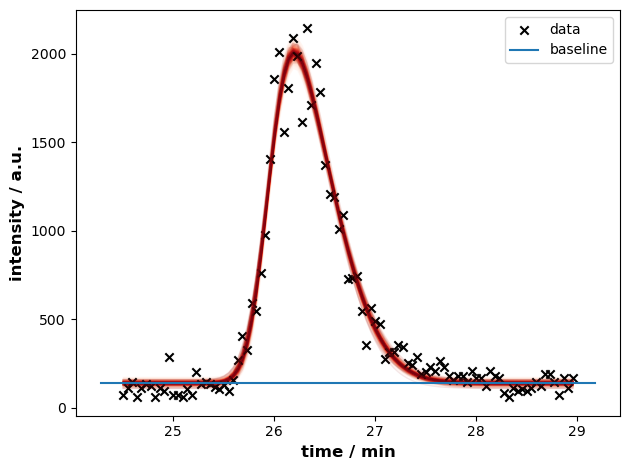

In [101]:
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_np,
    samples=idata3.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time_np, intensity_np, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
# plot baseline
x = np.array(ax.get_xlim())
y_baseline = az.summary(idata3).loc["baseline","mean"]
y = [y_baseline] * len(x)
print(y)
pyplot.plot(x, y, label = "baseline")
# pyplot.axvline(x = 25.95)
# pyplot.axvline(x = 26.345)
# pyplot.axvline(x = 26.488)
# pyplot.hlines([1856.0, 1807.0, 1947.0], xmin = 25, xmax = 29)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()
# pyplot.savefig("Skew_A1_t1_1_Part2_His110_M0_m0.png")

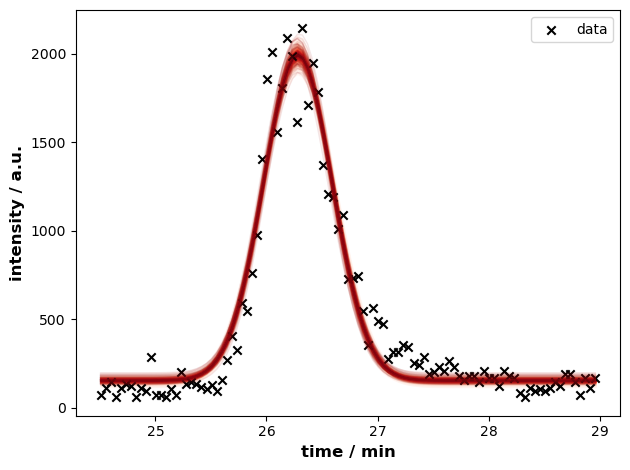

In [32]:
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_np,
    samples=idata2.posterior.y.stack(sample=("chain", "draw")).T.values,
)
pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_np,
    samples=idata3.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time_np, intensity_np, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

In [51]:
az.summary(idata3).loc[["mean", "std", "std_skew", "height", "area", "alpha", "baseline"],:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,25.951,0.013,25.927,25.975,0.000,0.000,3209.0,4084.0,1.0
std,0.523,0.022,0.483,0.564,0.000,0.000,2960.0,3793.0,1.0
std_skew,0.343,0.010,0.324,0.362,0.000,0.000,3421.0,4667.0,1.0
height,1739.723,39.928,1663.919,1812.976,0.494,0.350,6519.0,6402.0,1.0
area,1495.707,39.062,1423.452,1568.796,0.628,0.444,3858.0,4854.0,1.0
alpha,2.966,0.391,2.245,3.691,0.006,0.004,3772.0,4208.0,1.0
baseline,141.438,13.576,116.684,166.736,0.207,0.147,4278.0,5185.0,1.0


In [98]:
az.summary(idata3).loc[["mean", "mean_skew", "std", "std_skew", "height", "height2", "height3", "mode_skew", "area", "alpha", "baseline"],:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,25.950,0.013,25.926,25.974,0.000,0.000,3476.0,4136.0,1.0
mean_skew,26.346,0.012,26.322,26.368,0.000,0.000,4582.0,5680.0,1.0
std,0.524,0.022,0.483,0.565,0.000,0.000,3165.0,3977.0,1.0
std_skew,0.344,0.010,0.324,0.363,0.000,0.000,3748.0,4991.0,1.0
height,1140.975,41.064,1065.157,1217.789,0.653,0.463,4005.0,4941.0,1.0
height2,1714.813,70.773,1581.963,1844.316,1.149,0.815,3841.0,4852.0,1.0
height3,1867.151,38.615,1798.011,1942.961,0.435,0.307,7895.0,6650.0,1.0
mode_skew,26.203,0.011,26.182,26.223,0.000,0.000,6076.0,6229.0,1.0
area,1497.517,38.974,1424.722,1570.413,0.588,0.416,4396.0,5083.0,1.0
alpha,2.981,0.397,2.250,3.736,0.007,0.005,3550.0,4002.0,1.0


In [99]:
az.summary(idata3).loc["height3","mean"] + az.summary(idata3).loc["baseline","mean"]

2008.1190000000001

In [109]:
data_list = list(az.summary(idata3).iloc[:,0])
y = data_list[15:]
y

[140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.969,
 140.97,
 140.975,
 140.988,
 141.024,
 141.119,
 141.358,
 141.936,
 143.262,
 146.16,
 152.153,
 163.874,
 185.447,
 222.772,
 283.224,
 374.608,
 503.334,
 671.599,
 875.441,
 1103.276,
 1337.658,
 1557.932,
 1745.244,
 1885.77,
 1973.261,
 2008.459,
 1997.476,
 1949.188,
 1873.061,
 1777.568,
 1669.753,
 1554.907,
 1437.13,
 1319.323,
 1203.776,
 1092.242,
 985.944,
 885.937,
 792.845,
 707.183,
 629.117,
 558.734,
 495.852,
 440.224,
 391.489,
 349.15,
 312.722,
 281.634,
 255.352,
 233.305,
 214.981,
 199.865,
 187.509,
 177.481,
 169.413,
 162.974,
 157.873,
 153.865,
 150.739,
 148.32,
 146.462,
 145.046,
 143.974,
 143.169,
 142.569,
 142.125,
 141.798,
 141.56,
 141.387,
 141.263,
 141.174,
 141.111,
 141.067,
 141.036,
 141.014,
 140.999,
 140.989,
 140.982,
 140.977,
 140.974,
 140.972,
 140.971,
 140.97,
 140.969,
 140.969,
 140.968,
 140.968]

In [110]:
np.max(y)

2008.459

In [102]:
np.max(intensity_np)

2143.0

In [62]:
for a in intensity_np:
    if 0.95 * 1881 <= a <= 1.05 * 1881:
        print(a)

1856.0
1807.0
1947.0


In [59]:
np.sqrt(az.summary(idata3).loc["height","sd"] ** 2 + az.summary(idata3).loc["baseline","sd"] ** 2)

42.93535276435958

In [31]:
az.summary(idata2).loc[["mean", "std", "height", "area", "alpha"],:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,26.279,0.009,26.262,26.296,0.000,0.000,7181.0,5293.0,1.0
std,0.311,0.010,0.291,0.330,0.000,0.000,5010.0,4802.0,1.0
height,1840.697,47.630,1754.254,1933.868,0.509,0.360,8722.0,7103.0,1.0
area,1432.880,45.938,1342.742,1516.634,0.684,0.484,4522.0,4283.0,1.0
alpha,1.998,1.492,0.000,4.681,0.018,0.013,4550.0,2682.0,1.0


{24.505850000000002: 229.875, 24.5513: 229.875, 24.596766666666667: 229.875, 24.642216666666666: 229.875, 24.687683333333332: 229.875, 24.733133333333335: 229.875, 24.778599999999997: 229.875, 24.824066666666667: 229.875, 24.869516666666666: 229.875, 24.914983333333332: 229.875, 24.960433333333334: 229.875, 25.0059: 229.875, 25.05135: 229.875, 25.096816666666665: 229.875, 25.142266666666668: 229.876, 25.18773333333333: 229.88, 25.233183333333333: 229.893, 25.278650000000003: 229.931, 25.324116666666665: 230.038, 25.369566666666667: 230.325, 25.415033333333334: 231.056, 25.460483333333332: 232.817, 25.50595: 236.82, 25.5514: 245.373, 25.596866666666664: 262.534, 25.642316666666666: 294.747, 25.687783333333336: 351.259, 25.733249999999998: 443.608, 25.7787: 583.851, 25.824166666666667: 781.574, 25.869616666666666: 1039.431, 25.91508333333333: 1350.212, 25.960533333333334: 1694.876, 26.005999999999997: 2045.678, 26.05145: 2370.666, 26.09691666666667: 2641.533, 26.14238333333333: 2838.561,

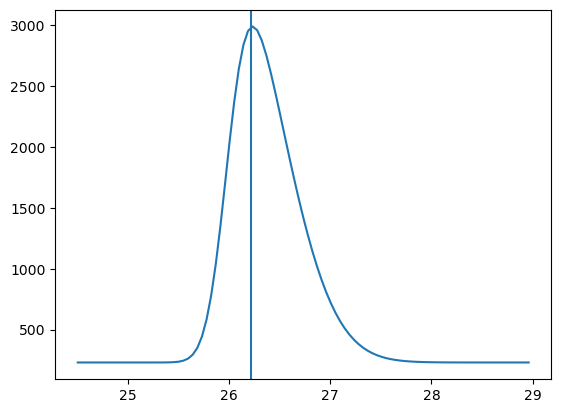

In [51]:
data_list = list(az.summary(idata).iloc[:,0])
y = data_list[7:]
y
pyplot.plot(time_np, y)
pyplot.axvline(x = 26.22195893367449)
print(dict(zip(time_np, y)))

In [33]:
raw_skewness = st.skew(intensity_np)
fit_skewness = st.skew(y)
print(raw_skewness, fit_skewness)

1.694191796628053 1.644267468365121


In [87]:
def calculate_mue_z(alpha):
    return np.sqrt(2/np.pi) * alpha / (np.sqrt(1 + alpha ** 2))

def calculate_sigma_z(mue_z):
    return np.sqrt(1 - mue_z ** 2)

def skew_mode(alpha, intensity):
    mue_z = calculate_mue_z(alpha)
    sigma_z = calculate_sigma_z(mue_z)
    fit_skewness = st.skew(intensity)

    return mue_z - (fit_skewness * sigma_z) / 2 - 1 / 2 * np.exp(- (2 * np.pi)/abs(alpha))

def mue_skew(mean, sigma, alpha):
    return mean + sigma * np.sqrt(2/np.pi) * alpha / (np.sqrt(1 + alpha ** 2))

def mode_pos(mue, skew_mode, alpha):
    if alpha < 0:
        return mue + skew_mode
    elif alpha > 0:
        return mue - skew_mode

In [88]:
alpha = az.summary(idata3).loc["alpha","mean"]
mean = az.summary(idata3).loc["mean","mean"]
sigma = az.summary(idata3).loc["std","mean"]
print(alpha)
data_list = list(az.summary(idata3).iloc[:,0])
y = data_list[8:]
print(y)

mode_test = skew_mode(alpha, y)
mue = mue_skew(mean, sigma, alpha)
mode_pos(mue, mode_test, alpha)

2.972
[26.346, 1716.41, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.369, 141.374, 141.387, 141.423, 141.518, 141.757, 142.333, 143.655, 146.543, 152.514, 164.189, 185.68, 222.862, 283.094, 374.173, 502.528, 670.412, 873.946, 1101.639, 1336.109, 1556.709, 1744.531, 1885.65, 1973.706, 2009.354, 1998.657, 1950.486, 1874.328, 1778.692, 1670.66, 1555.558, 1437.512, 1319.441, 1203.651, 1091.901, 985.421, 885.268, 792.068, 706.334, 628.23, 557.841, 494.978, 439.394, 390.719, 348.455, 312.112, 281.114, 254.923, 232.968, 214.733, 199.702, 187.423, 177.468, 169.464, 163.082, 158.031, 154.066, 150.977, 148.589, 146.757, 145.362, 144.308, 143.517, 142.929, 142.493, 142.174, 141.941, 141.773, 141.652, 141.566, 141.505, 141.462, 141.432, 141.411, 141.397, 141.387, 141.38, 141.376, 141.373, 141.371, 141.369, 141.368, 141.368, 141.367, 141.367, 141.367]


26.16393909888036

In [15]:
delta = time_np[-1]-time_np[0]
time_np[0]+mode_test*delta

25.236685669045258

In [38]:
delta = time_np[-1]-time_np[0]
25.951+mode_test*delta

26.655320343080646